## Frequency response of 3D-waveguide

In [25]:
import fenics as fen
import mshr
import helpers
import numpy as np
import matplotlib.pyplot as plt
import wg3D
import scipy.sparse
import scipy.sparse.linalg

In [26]:
def get_solution_L2_norms(omegas, K, M, L, bc, V):
    L2_norms = np.empty(len(omegas))
    F = fen.assemble(fen.dot(fen.TrialFunction(V), fen.TestFunction(V))*fen.dx)
    F_mat = fen.as_backend_type(F).mat()
    F_sparse = scipy.sparse.coo_matrix(scipy.sparse.csr_matrix(F_mat.getValuesCSR()[::-1]))
    for i, omega in enumerate(omegas):
        A = wg3D.solve(omega, K, M, L, bc, V).vector().get_local()
        L2_norms[i] = pow(A.T @ F_sparse @ A, 0.5)
    return L2_norms

In [28]:
def get_analytical_eigenvalues(Lx, Ly, Lz, a, b):
    freqs = lambda n, m, l: np.pi*pow(n**2/(Lx)**2 + m**2/(Ly)**2 + (l+0.5)**2/(Lz)**2 , 0.5)
    n_max = np.ceil(b * Lx / np.pi).astype('int')
    m_max = np.ceil(b * Ly / np.pi).astype('int')
    l_max = np.ceil(b * Lz / np.pi - 0.5).astype('int')
    eigs_nml = np.empty((n_max, m_max+1, l_max+1))
    for n in range(1, n_max+1):
        for m in range(m_max+1):
            for l in range(l_max+1):
                eigs_nml[n-1, m, l] = freqs(n, m, l)
    eigs = np.unique(eigs_nml)
    return [x for x in eigs if a <= x and x <= b]

### Create waveguide and set boundary conditions

In [29]:
Lx = 1.0
Ly = 1.0
Lz = 5.0

mu = fen.Expression('1.0', degree=2) # 4*np.pi*1e-7 # magnetic permeability inside waveguide
eps = fen.Expression('1.0', degree=2) # 8.854187e-12 # electric permittivity inside waveguide
g_inlet = fen.Expression(('1.0', '0.0', '0.0'), degree=2)

mesh = fen.BoxMesh(fen.Point(0, 0, 0), fen.Point(Lx, Ly, Lz), 10, 10, 50)

class Inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[2], 0) and x[0]>0 and x[0]<Lx and x[1]>0 and x[1]<Ly
    
boundary, V, bc = wg3D.create(mesh, Inlet())

### Get stiffness and mass matrices and add forcing term

In [30]:
# Setup
K, M, L = wg3D.setup(boundary, g_inlet, mu, eps, V)

### Observe frequency response

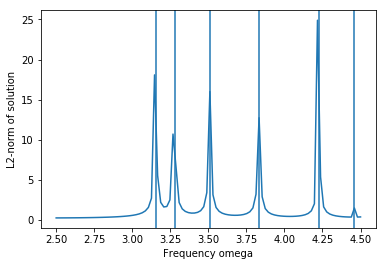

In [32]:
# Observe frequency response
omegas = np.linspace(2.5, 4.5, 100)
L2_norms =  get_solution_L2_norms(omegas, K, M, L, bc, V)
plt.plot(omegas, L2_norms)
plt.xlabel('Frequency omega')
plt.ylabel('L2-norm of solution')

# Expected location of peaks
ev = get_analytical_eigenvalues(Lx, Ly, Lz, omegas[0], omegas[-1])
[plt.axvline(x) for x in ev]
plt.show()